In [35]:
# Entrenamiento Latitudes y Longitudes
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

#Modelo Tensor
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2


In [36]:
# Cargamos el Dataset
file_path = "dataset/dataset.csv"
df = pd.read_csv(file_path)

In [37]:
#Listamos columnas para X y con drop separamos como un filter
X_columns = [
    'latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'fc', 'elevation', 
    'azimuth', 'year', 'mmdd', 'UTI', 'hour', 'delay', 'terrestrial_range', 
    'slant_range', 'final_latitude', 'final_longitude', 'final_elevation'
]
X = df[X_columns]
Y = df.drop(columns=X_columns)
#Parametros del dataset que no corresponden al X de entrenamiento.
X = X.drop(columns=['final_latitude','final_longitude','final_elevation'])

# Como solo vamos a observar las latitudes y longitudes, quitamos las alturas.
lat_columns = [f'lat_{i}' for i in range(1,101)]
long_columns = [f'long_{i}' for i in range(1,101)]
heights_columns = [f'elev_{i}' for i in range(1,101)]

Y = Y.drop(columns = heights_columns)
# Otras columnas que no tendré en cuenta para la predicción son 
# "delay", "terrestrial_range", "slant_range", por lo que las quito
unwanted_columns = ["delay","terrestrial_range","slant_range"]
X = X.drop(columns=unwanted_columns)


In [38]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state = 42)


In [39]:
# Normalizamos la Frecuencia de los X 
k_norm = 1E6
x_train["fc"] = x_train["fc"]/k_norm
x_test["fc"] = x_test["fc"]/k_norm
#decidimos tomar todas las decimas.
x_test.head()

,latitude_pos_tx,longitude_pos_tx,elevation_pos_tx,fc,elevation,azimuth,year,mmdd,UTI,hour
5104,-42.28,-63.4,0,30.0,30,91,2010.0,1215,0,12
2186,-42.28,-63.4,0,10.0,5,98,2010.0,1231,0,8
4371,-42.28,-63.4,0,23.0,32,88,2010.0,1215,0,12
831,-42.28,-63.4,0,10.0,5,98,2010.0,519,0,12
1421,-42.28,-63.4,0,10.0,5,98,2010.0,825,0,20


In [40]:
# Sección si es necesario Normalizar o no, las latitudes y longitudes

# Modelo Red Neuronal capas
l2_reg = 0.005
inputs = Input(shape =(10,))
encoded = Dense(8, activation = 'relu',kernel_regularizer=l2(l2_reg))(inputs)
encoded = Dense(16, activation = "relu",kernel_regularizer=l2(l2_reg))(encoded)
encoded = Dense(32, activation = "relu",kernel_regularizer=l2(l2_reg))(encoded)
encoded = Dense(64, activation = "relu",kernel_regularizer=l2(l2_reg))(encoded)
decoded = Dense(200, activation = 'linear',kernel_regularizer=l2(l2_reg))(encoded)

autoencoder = Model(inputs,decoded)
autoencoder.compile(optimizer = 'adam', loss='mse')
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 200)            │        13,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,888 (62.06 KB)

 Trainable params: 15,888 (62.06 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Entrenamiento
history = autoencoder.fit(x_train,y_train, epochs=120, batch_size = 80,
                          validation_data = (x_test,y_test))

Epoch 1/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5737.5991 - val_loss: 84.6748
Epoch 2/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.0976 - val_loss: 24.2743
Epoch 3/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.9705 - val_loss: 18.3988
Epoch 4/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.5893 - val_loss: 17.0891
Epoch 5/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.4788 - val_loss: 16.5681
Epoch 6/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2478 - val_loss: 16.6113
Epoch 7/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.1564 - val_loss: 16.4421
Epoch 8/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.3196 - val_loss: 16.4376
Epoch 9/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.1050 - val_loss: 16.2881
Epoch 10/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.0602 - val_loss: 16.3202
Epoch 11/120
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3890 - val_loss: 16.5545
Epoch 12/120
52/52 ━━━━━━━━━━━━━━━━━━━━

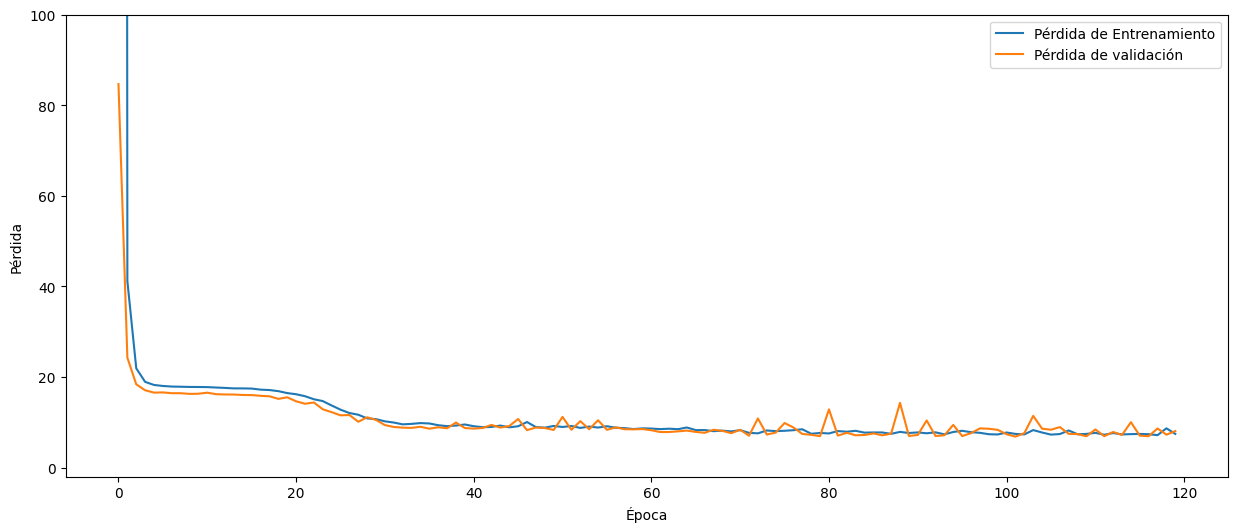

In [42]:
# Función de Pérdida durante el entrenamiento
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label = 'Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label = 'Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.ylim(-2,100)
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


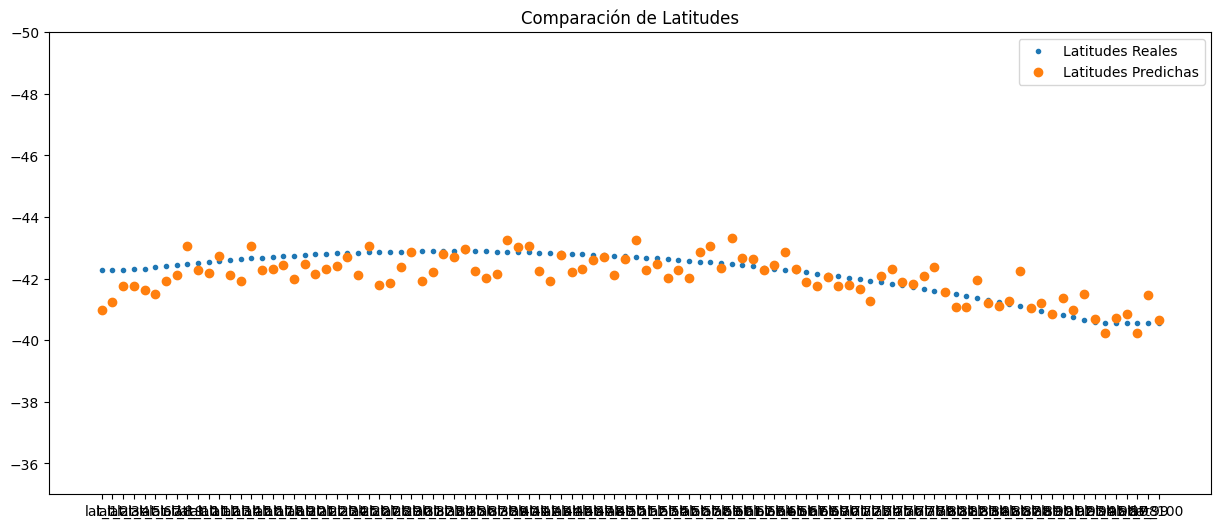

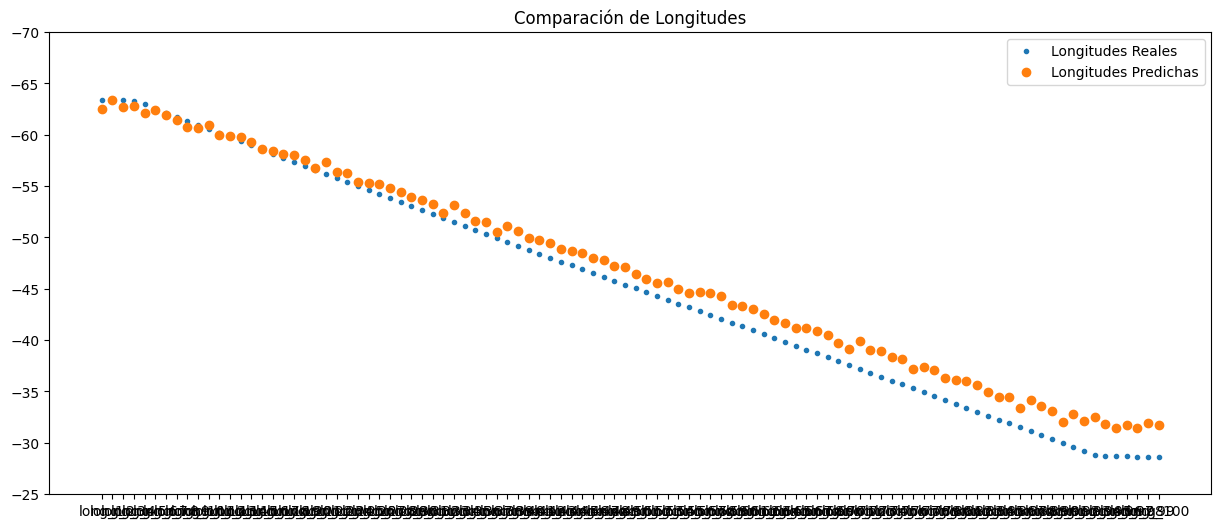

In [46]:
# Predecimos una muestra en particular de mi df
idx =110

y_pred = autoencoder.predict(np.expand_dims(x_test.iloc[idx], axis = 0))

y_true =y_test.iloc[idx]
# Separamos Latitudes Longitudes
y_true_latitudes = y_true[0:100]
y_true_longitudes = y_true[100:200]

y_pred_latitudes = y_pred[0,0:100]
y_pred_longitudes = y_pred[0,100:200]

# Grafica Latitudes 
plt.figure(figsize = (15,6))
plt.plot(y_true_latitudes, label = 'Latitudes Reales', linestyle = 'None', marker = '.')
plt.plot(y_pred_latitudes, label = 'Latitudes Predichas', linestyle = 'None', marker = 'o')
plt.ylim(-35,-50)
plt.title('Comparación de Latitudes')
plt.legend()
plt.show()

# Graf. Longitudes
plt.figure(figsize=(15,6))
plt.plot(y_true_longitudes,label= 'Longitudes Reales', linestyle = 'None',marker= '.')
plt.plot(y_pred_longitudes,label= 'Longitudes Predichas', linestyle = 'None', marker = 'o')
plt.ylim(-25,-70)
plt.title("Comparación de Longitudes")
plt.legend()
plt.show()

In [44]:
save_model = False

if save_model == True:
  autoencoder.save('modelos_entrenamiento/fit_lat_lon.h5')